# Classification SVHN using CNN
## Importing libraries

In [ ]:
!pip install torchvision scikit-learn

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import numpy as np


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 110.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 64.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 46.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 780.5 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 35.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvji

In [ ]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# Transformasi data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])


In [ ]:
# Load Dataset SVHN
train_set = datasets.SVHN(root='./data', split='train', download=True, transform=transform)
test_set = datasets.SVHN(root='./data', split='test', download=True, transform=transform)
train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
test_loader = DataLoader(test_set, batch_size=64, shuffle=False)


In [ ]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 8 * 8, 256)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))  # -> 16x16x32
        x = self.pool(torch.relu(self.conv2(x)))  # -> 8x8x64
        x = x.view(-1, 64 * 8 * 8)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

    def fit(self, train_loader, val_loader, epochs=10, optimizer=None, criterion=None, device='cpu'):
        import time
        from tqdm import tqdm

        for epoch in range(epochs):
            self.train()
            running_loss = 0.0
            correct = 0
            total = 0
            start_time = time.time()

            bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", unit="batch")
            for images, labels in bar:
                images, labels = images.to(device), labels.to(device)

                optimizer.zero_grad()
                outputs = self(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                running_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                acc = correct / total
                bar.set_postfix(loss=loss.item(), accuracy=acc)

            train_accuracy = correct / total
            train_loss = running_loss / len(train_loader)

            # Validation
            self.eval()
            val_correct, val_total, val_loss = 0, 0, 0.0
            with torch.no_grad():
                for images, labels in val_loader:
                    images, labels = images.to(device), labels.to(device)
                    outputs = self(images)
                    loss = criterion(outputs, labels)
                    val_loss += loss.item()
                    _, predicted = torch.max(outputs, 1)
                    val_total += labels.size(0)
                    val_correct += (predicted == labels).sum().item()

            val_accuracy = val_correct / val_total
            val_loss /= len(val_loader)
            duration = time.time() - start_time

            print(f"{len(train_loader)}/{len(train_loader)} "
                  f"{int(duration)}s {int(duration / len(train_loader) * 1000)}ms/step - "
                  f"accuracy: {train_accuracy:.4f} - loss: {train_loss:.4f} - "
                  f"val_accuracy: {val_accuracy:.4f} - val_loss: {val_loss:.4f}")


In [ ]:
class MLPModel(nn.Module):
    def __init__(self):
        super(MLPModel, self).__init__()
        self.fc1 = nn.Linear(3 * 32 * 32, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 10)

    def forward(self, x):
        x = x.view(-1, 3 * 32 * 32)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def fit(self, train_loader, val_loader, epochs=10, optimizer=None, criterion=None, device='cpu'):
        import time
        from tqdm import tqdm

        for epoch in range(epochs):
            self.train()
            running_loss = 0.0
            correct = 0
            total = 0
            start_time = time.time()

            bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", unit="batch")
            for images, labels in bar:
                images, labels = images.to(device), labels.to(device)

                optimizer.zero_grad()
                outputs = self(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                running_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                acc = correct / total
                bar.set_postfix(loss=loss.item(), accuracy=acc)

            train_accuracy = correct / total
            train_loss = running_loss / len(train_loader)

            # Validation
            self.eval()
            val_correct, val_total, val_loss = 0, 0, 0.0
            with torch.no_grad():
                for images, labels in val_loader:
                    images, labels = images.to(device), labels.to(device)
                    outputs = self(images)
                    loss = criterion(outputs, labels)
                    val_loss += loss.item()
                    _, predicted = torch.max(outputs, 1)
                    val_total += labels.size(0)
                    val_correct += (predicted == labels).sum().item()

            val_accuracy = val_correct / val_total
            val_loss /= len(val_loader)
            duration = time.time() - start_time

            print(f"{len(train_loader)}/{len(train_loader)} "
                  f"{int(duration)}s {int(duration / len(train_loader) * 1000)}ms/step - "
                  f"accuracy: {train_accuracy:.4f} - loss: {train_loss:.4f} - "
                  f"val_accuracy: {val_accuracy:.4f} - val_loss: {val_loss:.4f}")


In [ ]:
# === FUNGSI TRAINING DAN EVALUASI ===
def train(model, loader, criterion, optimizer, device):
    model.train()
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

def evaluate(model, loader, device):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.numpy())
            y_pred.extend(preds.cpu().numpy())
    return y_true, y_pred

In [ ]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

def evaluate_with_probs(model, loader, device):
    model.eval()
    y_true = []
    y_probs = []
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            outputs = model(images)
            probs = torch.softmax(outputs, dim=1)
            y_true.extend(labels.cpu().numpy())
            y_probs.extend(probs.cpu().numpy())
    return np.array(y_true), np.array(y_probs)



In [ ]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

def plot_auc_roc(y_true, y_probs, title='AUC-ROC Curve'):
    y_true_bin = label_binarize(y_true, classes=np.arange(10))
    auc_score = roc_auc_score(y_true_bin, y_probs, average='macro', multi_class='ovr')

    print(f"AUC Score (macro-averaged): {auc_score:.4f}")

    plt.figure(figsize=(10, 8))
    for i in range(10):
        fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_probs[:, i])
        plt.plot(fpr, tpr, label=f"Class {i}")

    plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()


In [ ]:
# === TRAIN DAN EVALUASI CNN ===
cnn = CNNModel().to(device)
optimizer_cnn = optim.Adam(cnn.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

cnn.fit(train_loader, test_loader, epochs=2, optimizer=optimizer_cnn, criterion=criterion, device=device)


Epoch 1/2: 100%|██████████| 1145/1145 [00:25<00:00, 45.20batch/s, accuracy=0.758, loss=0.224]


1145/1145 32s 28ms/step - accuracy: 0.7582 - loss: 0.7907 - val_accuracy: 0.8388 - val_loss: 0.5647


Epoch 2/2: 100%|██████████| 1145/1145 [00:24<00:00, 47.66batch/s, accuracy=0.875, loss=0.318]


1145/1145 30s 26ms/step - accuracy: 0.8754 - loss: 0.4270 - val_accuracy: 0.8640 - val_loss: 0.4697


In [ ]:
# === TRAIN DAN EVALUASI MLP ===
mlp = MLPModel().to(device)
optimizer_mlp = optim.Adam(mlp.parameters(), lr=0.001)

mlp.fit(train_loader, test_loader, epochs=2, optimizer=optimizer_mlp, criterion=criterion, device=device)


Epoch 1/2: 100%|██████████| 1145/1145 [00:22<00:00, 50.38batch/s, accuracy=0.623, loss=1.01]


1145/1145 32s 28ms/step - accuracy: 0.6233 - loss: 1.1691 - val_accuracy: 0.6785 - val_loss: 1.0690


Epoch 2/2: 100%|██████████| 1145/1145 [00:23<00:00, 48.24batch/s, accuracy=0.754, loss=0.636]


1145/1145 29s 25ms/step - accuracy: 0.7536 - loss: 0.8009 - val_accuracy: 0.7467 - val_loss: 0.8892


AUC Score (macro-averaged): 0.9853


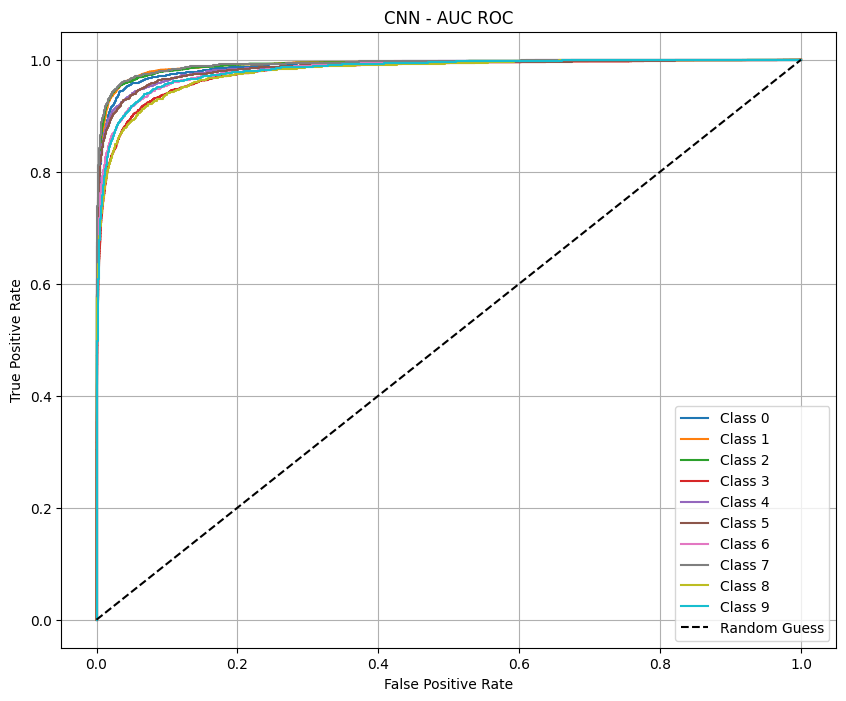

AUC Score (macro-averaged): 0.9501


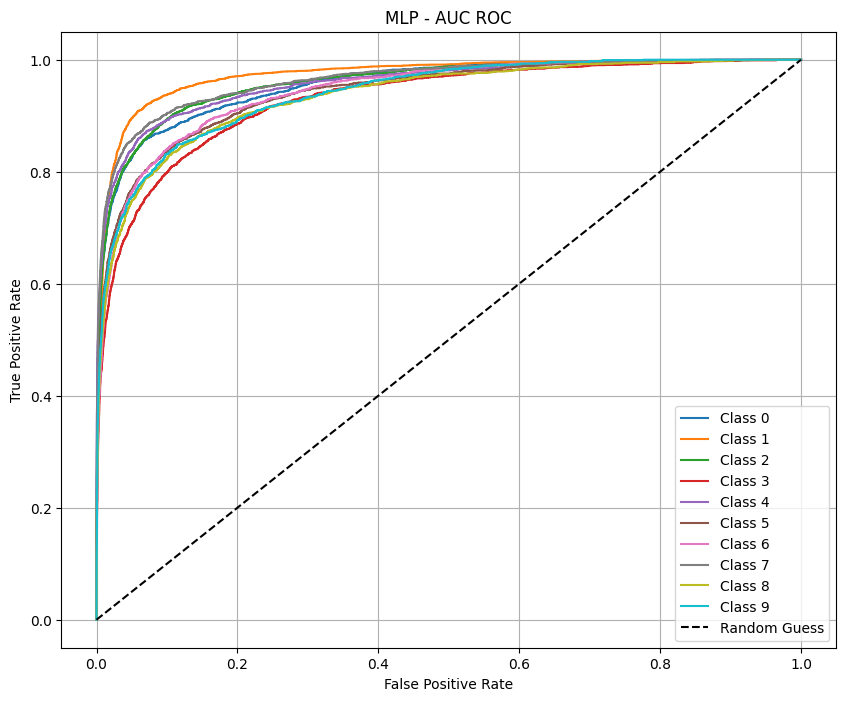

In [ ]:
# === EVALUASI CNN ===
y_true_cnn, y_probs_cnn = evaluate_with_probs(cnn, test_loader, device)
plot_auc_roc(y_true_cnn, y_probs_cnn, title='CNN - AUC ROC')

# === EVALUASI MLP ===
y_true_mlp, y_probs_mlp = evaluate_with_probs(mlp, test_loader, device)
plot_auc_roc(y_true_mlp, y_probs_mlp, title='MLP - AUC ROC')


In [ ]:
# === METRIK EVALUASI ===
def evaluate_all(name, y_true, y_pred, y_probs):
    from sklearn.preprocessing import label_binarize
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

    # Binarize true labels for AUC-ROC
    y_true_bin = label_binarize(y_true, classes=np.arange(10))

    # Hitung metrik
    accuracy = accuracy_score(y_true, y_pred) * 100  # dalam persen
    precision = precision_score(y_true, y_pred, average='macro', zero_division=0)
    recall = recall_score(y_true, y_pred, average='macro', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='macro', zero_division=0)
    auc = roc_auc_score(y_true_bin, y_probs, average='macro', multi_class='ovr')

    # Tampilkan hasil
    print(f"\n {name} - Evaluasi Model:")
    print(f"Akurasi Testing : {accuracy:.2f}%")
    print(f"Presisi         : {precision:.4f}")
    print(f"Recall          : {recall:.4f}")
    print(f"F1 Score        : {f1:.4f}")
    print(f"AUC-ROC         : {auc:.4f}")


In [ ]:
evaluate_all("CNN", y_true_cnn, y_pred_cnn, y_probs_cnn)
evaluate_all("MLP", y_true_mlp, y_pred_mlp, y_probs_mlp)



 CNN - Evaluasi Model:
Akurasi Testing : 86.81%
Presisi         : 0.8591
Recall          : 0.8531
F1 Score        : 0.8545
AUC-ROC         : 0.9853

 MLP - Evaluasi Model:
Akurasi Testing : 73.14%
Presisi         : 0.7152
Recall          : 0.7170
F1 Score        : 0.7122
AUC-ROC         : 0.9501


In [ ]:
def plot_confusion_matrices_side_by_side(y_true1, y_pred1, y_true2, y_pred2,
                                          title1="CNN - Confusion Matrix", title2="MLP - Confusion Matrix"):
    cm1 = confusion_matrix(y_true1, y_pred1)
    cm2 = confusion_matrix(y_true2, y_pred2)

    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    sns.heatmap(cm1, annot=True, fmt="d", cmap="Blues", xticklabels=np.arange(10),
                yticklabels=np.arange(10), ax=axes[0])
    axes[0].set_title(title1)
    axes[0].set_xlabel("Predicted")
    axes[0].set_ylabel("Actual")

    sns.heatmap(cm2, annot=True, fmt="d", cmap="Greens", xticklabels=np.arange(10),
                yticklabels=np.arange(10), ax=axes[1])
    axes[1].set_title(title2)
    axes[1].set_xlabel("Predicted")
    axes[1].set_ylabel("Actual")

    plt.tight_layout()
    plt.show()


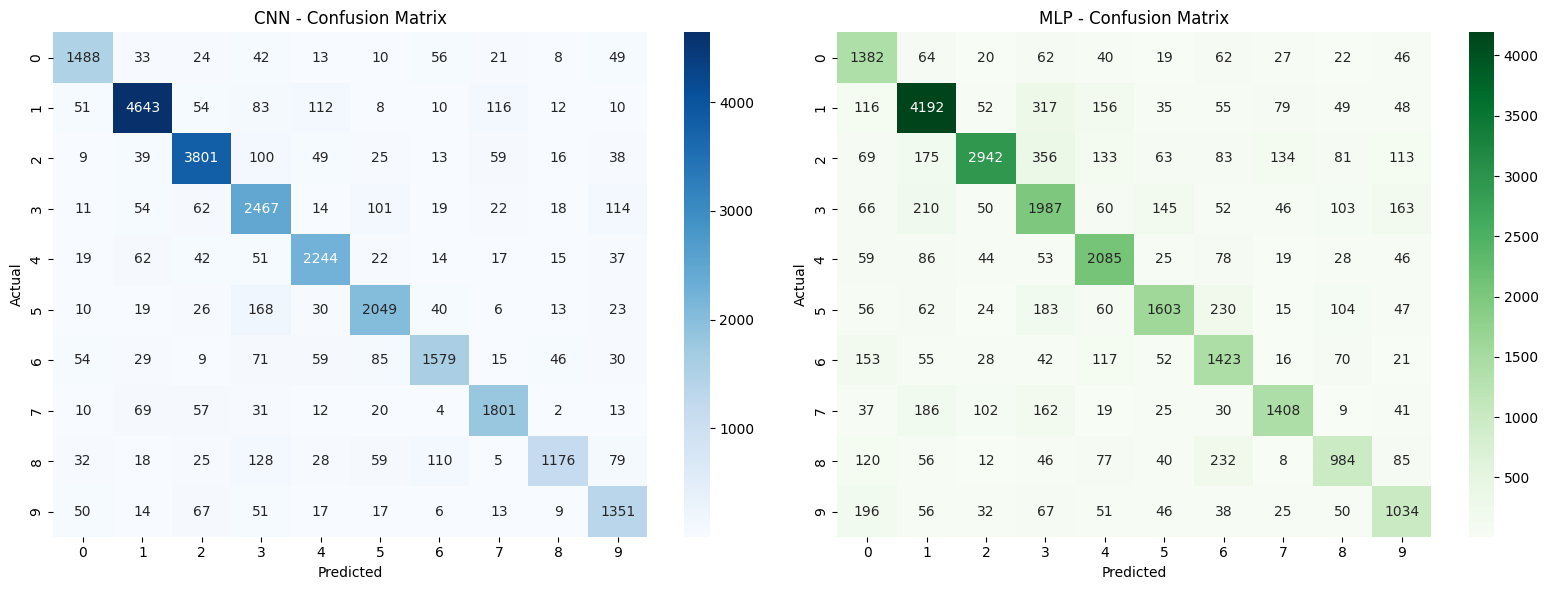

In [ ]:
plot_confusion_matrices_side_by_side(
    y_true_cnn, y_pred_cnn,
    y_true_mlp, y_pred_mlp,
    title1="CNN - Confusion Matrix",
    title2="MLP - Confusion Matrix"
)


# Kesimpulan Evaluasi Model

## 1. CNN (Convolutional Neural Network)
Model CNN menunjukkan performa yang sangat baik untuk klasifikasi gambar angka rumah (SVHN), dengan hasil sebagai berikut:
- **Akurasi Testing**: **86.81%**
- **Presisi**: 0.8591
- **Recall**: 0.8531
- **F1 Score**: 0.8545
- **AUC-ROC**: 0.9853

**Kesimpulan**:  
CNN mampu mengekstrak fitur spasial dengan baik melalui lapisan konvolusinya, sehingga model ini memiliki akurasi tinggi, prediksi stabil, dan generalisasi yang kuat terhadap data uji. Nilai AUC-ROC yang sangat tinggi menunjukkan kemampuan membedakan antar kelas dengan sangat baik.

---

## 2. MLP (Multilayer Perceptron)
Model MLP memberikan hasil yang cukup baik, meskipun tidak sekuat CNN:
- **Akurasi Testing**: **73.14%**
- **Presisi**: 0.7152  
- **Recall**: 0.7170  
- **F1 Score**: 0.7122  
- **AUC-ROC**: 0.9501

**Kesimpulan**:  
MLP bekerja cukup baik, namun karena tidak memanfaatkan struktur spasial dari gambar (hanya lapisan fully connected), performanya tertinggal dibandingkan CNN. Meskipun demikian, MLP tetap valid sebagai baseline model.

---

## Perbandingan Singkat

| Metrik       | CNN        | MLP        |
|--------------|------------|------------|
| Akurasi (%)  | **86.81**  | 73.14      |
| Presisi      | **0.8591** | 0.7152     |
| Recall       | **0.8531** | 0.7170     |
| F1 Score     | **0.8545** | 0.7122     |
| AUC-ROC      | **0.9853** | 0.9501     |

---

## Rekomendasi
Jika tujuan utamanya adalah akurasi dan performa optimal untuk klasifikasi gambar, maka **CNN sangat direkomendasikan** sebagai model utama.  
MLP dapat digunakan untuk eksperimen awal atau pada sistem dengan keterbatasan komputasi.


# Penjelasan Persamaan Matematika untuk Metrik Evaluasi

## 1. **Akurasi (Accuracy)**
Akurasi mengukur seberapa sering model membuat prediksi yang benar dibandingkan dengan total data yang diuji.

### Persamaan:
$$
\text{Akurasi} = \frac{\text{Jumlah Prediksi Benar}}{\text{Jumlah Total Data}}
$$
- **Jumlah Prediksi Benar**: Jumlah klasifikasi yang benar oleh model.
- **Jumlah Total Data**: Jumlah total sampel yang diuji.

Akurasi dihitung dalam bentuk **persen** untuk memudahkan pemahaman.

---

## 2. **Presisi (Precision)**
Presisi mengukur seberapa tepat model dalam mengklasifikasikan sampel positif (misalnya kelas 1) dari semua yang diprediksi sebagai positif.

### Persamaan:
$$
\text{Presisi} = \frac{\text{True Positives (TP)}}{\text{True Positives (TP) + False Positives (FP)}}
$$
- **True Positives (TP)**: Jumlah prediksi yang benar untuk kelas positif.
- **False Positives (FP)**: Jumlah prediksi yang salah untuk kelas positif.

Presisi menunjukkan **seberapa banyak dari prediksi positif yang benar-benar positif**.

---

## 3. **Recall (Sensitivity)**
Recall mengukur seberapa banyak prediksi positif yang benar-benar ditemukan dari total data yang sebenarnya positif.

### Persamaan:
$$
\text{Recall} = \frac{\text{True Positives (TP)}}{\text{True Positives (TP) + False Negatives (FN)}}
$$
- **True Positives (TP)**: Jumlah prediksi yang benar untuk kelas positif.
- **False Negatives (FN)**: Jumlah data positif yang salah diklasifikasikan sebagai negatif.

Recall menunjukkan **seberapa banyak dari data positif yang dapat ditemukan oleh model**.

---

## 4. **F1 Score**
F1 Score adalah rata-rata harmonik dari presisi dan recall, memberikan gambaran umum tentang keseimbangan antara keduanya.

### Persamaan:
$$
\text{F1 Score} = 2 \cdot \frac{\text{Presisi} \cdot \text{Recall}}{\text{Presisi} + \text{Recall}}
$$
- **Presisi**: Seberapa tepat prediksi positif model.
- **Recall**: Seberapa banyak prediksi positif yang benar ditemukan.

F1 Score digunakan untuk menghindari ketidakseimbangan antara presisi dan recall, memberikan bobot yang lebih seimbang pada keduanya.

---

## 5. **AUC-ROC (Area Under the Curve - Receiver Operating Characteristic)**
AUC-ROC adalah metrik yang digunakan untuk mengevaluasi performa model klasifikasi, khususnya dalam kasus **multi-class classification**. AUC menunjukkan kemampuan model untuk membedakan antara kelas-kelas yang berbeda.

- **ROC Curve**: Grafik yang menunjukkan trade-off antara **True Positive Rate (TPR)** dan **False Positive Rate (FPR)** di berbagai threshold.

### Persamaan untuk AUC:
$$
\text{AUC} = \text{Area Under the ROC Curve}
$$
- **True Positive Rate (TPR)**: Sama dengan Recall, yaitu seberapa banyak prediksi positif yang benar ditemukan.
- **False Positive Rate (FPR)**: Mengukur seberapa banyak prediksi negatif yang salah diklasifikasikan sebagai positif.

Nilai AUC berkisar antara 0 hingga 1:
- **AUC = 1**: Model sempurna dalam membedakan kelas positif dan negatif.
- **AUC = 0.5**: Model tidak lebih baik dari tebakan acak.

AUC mengukur kemampuan model dalam mengklasifikasikan kelas positif dan negatif secara keseluruhan, terlepas dari threshold yang digunakan.

---
